In [44]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx

In [45]:
def load_results(models, experiments, base_dir):
    results = dict()
    bird_scales = dict()
    fluxes = [dict(), dict()]
    att = dict()
    for i, m in enumerate(models):

        experiment = experiments[i]

        # load predictions
        model_dir = osp.join(base_dir, 'testing', m, experiment)
        files = glob.glob(model_dir + "/**/results.csv", recursive = True)
        results[m] = pd.read_csv(files[0])

        # load bird scales
        fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
        with open(fp) as f:
            cfg = load(f, Loader=Loader)
        bird_scales[m] = cfg['datasource']['bird_scale']
        
        if m == 'BirdFluxGraphLSTM':
            files = glob.glob(model_dir + "/**/local_fluxes_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[0][r] = pickle.load(f)
            files = glob.glob(model_dir + "/**/radar_fluxes_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[1][r] = pickle.load(f)
        if m == 'AttentionGraphLSTM':
            files = glob.glob(model_dir + "/**/attention_weights_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    att[r] = pickle.load(f)
    return results, bird_scales, fluxes, att

In [105]:
def compare_fluxes(radar_index, fluxes_model, fluxes_radar, trial=0, context=0):
    f_model = torch.cat([f for f in fluxes_model[trial].values()], dim=-1)
    f_model = f_model - f_model.permute(1, 0, 2)
    f_radar = torch.cat([f[..., context:] for f in fluxes_radar[trial].values()], dim=-1)
    
    f_model = f_model[radar_index]
    f_radar = f_radar[radar_index]
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(f_radar.view(-1).detach().numpy(), 
               f_model.view(-1).detach().numpy(), alpha=0.2)
    ax.set(xlabel='radar fluxes', ylabel='model fluxes');

In [61]:
def plot_fluxes(voronoi, G, fluxes, results, trial=0, encoder=0, context=0, bird_scale=1):

    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    f = torch.cat([f[..., context:] for f in fluxes[trial].values()], dim=-1)
    mask = np.concatenate([results['BirdFluxGraphLSTM'].query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
                           for i in range(len(fluxes[trial]))])


    radars = results['BirdFluxGraphLSTM'].radar.unique()
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val = np.nanmean(f[j,i,mask].detach().numpy()) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j,mask].detach().numpy())
            #print(val)
            if val != 0:
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                #if val > 0 and not boundary1 and not boundary2:
                if not boundary1 and not boundary2:
#                     print(val, val2)
                    G_new.add_edge(j, i, flux=val)

    pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    fluxes *= bird_scale
    norm = plt.Normalize(fluxes.min(), fluxes.max())
    edge_colors = cmap(norm(fluxes))

    fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
    ax.set(title='averaged inferred fluxes between radars')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='bird density');
    return G_new

In [48]:
def plot_sensitivity(results, sigmas, m):
    rmse = []
    for r in results:
        rmse.append(r[m].groupby('trial').error.aggregate(np.nanmean).apply(np.sqrt).values)
    rmse = np.stack(rmse)
    fig, ax = plt.subplots()
    ax.plot(sigmas, rmse.mean(1), '-o', label='perturbed BirdFluxGraphLSTM')
    ax.fill_between(sigmas, rmse.mean(1) - rmse.std(1), rmse.mean(1) + rmse.std(1), alpha=0.2)
    ref_rmse = results[0]['LocalLSTM'].groupby('trial').error.aggregate(np.nanmean).apply(np.sqrt).values
    ax.plot(sigmas, [ref_rmse.mean()] * len(sigmas), label='LocalLSTM')
    ax.fill_between(sigmas, [ref_rmse.mean() - ref_rmse.std()] * len(sigmas), [ref_rmse.mean() + ref_rmse.std()] * len(sigmas), alpha=0.2)
    ax.set(xlabel='perturbation std [birds/km2]', ylabel='RMSE')
    ax.legend()
    return fig

In [99]:
base_dir = '/home/fiona/birdMigration/results/radar'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
boundary = voronoi.query('boundary == True').radar.values
inner_idx = voronoi.query('boundary == False').index.values

In [78]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'fixed_boundary_with_h_j']
results_fixed_boundary, bird_scales_fixed_boundary, fluxes_fixed_boundary, _ = load_results(models, experiments, base_dir)

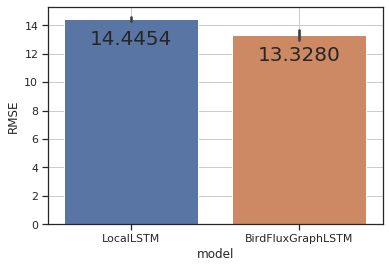

In [79]:
fig = utils.plot_average_errors(results_fixed_boundary, boundary=boundary, night_only=True)

In [80]:
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/fixed_boundary_performance.png', bbox_inches='tight', dpi=300)

### Random perturbations on boundary radars with $\mathcal{N}(\mu=0, \sigma=0.2)$

In [76]:
print(f'std of 0.2 means std of {0.2 * 293} birds/km2')

std of 0.2 means std of 58.6 birds/km2


In [99]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'fixed_boundary_with_h_j']
results_fixed_boundary_std02, _, fluxes_fixed_boundary_std02, _ = load_results(models, experiments, base_dir)

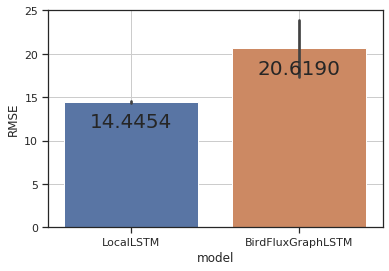

In [100]:
fig = utils.plot_average_errors(results_fixed_boundary_std02, boundary=boundary, night_only=True)

### Random perturbations on boundary radars with $\mathcal{N}(\mu=0, \sigma=0.15)$

In [109]:
print(f'std of 0.15 means std of {0.15 * 293} birds/km2')

std of 0.15 means std of 43.949999999999996 birds/km2


In [107]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'fixed_boundary_with_h_j']
results_fixed_boundary_std015, _, fluxes_fixed_boundary_std015, _ = load_results(models, experiments, base_dir)

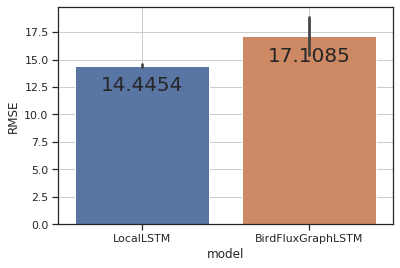

In [108]:
fig = utils.plot_average_errors(results_fixed_boundary_std015, boundary=boundary, night_only=True)

### Random perturbations on boundary radars with $\mathcal{N}(\mu=0, \sigma=0.1)$

In [78]:
print(f'std of 0.1 means std of {0.1 * 293} birds/km2')

std of 0.1 means std of 29.3 birds/km2


In [110]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'fixed_boundary_with_h_j']
results_fixed_boundary_std01, _, fluxes_fixed_boundary_std01, _ = load_results(models, experiments, base_dir)

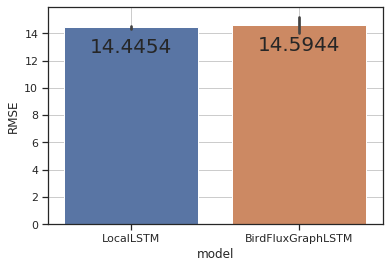

In [111]:
fig = utils.plot_average_errors(results_fixed_boundary_std01, boundary=boundary, night_only=True)

### Random perturbations on boundary radars with $\mathcal{N}(\mu=0, \sigma=0.05)$

In [79]:
print(f'std of 0.05 means std of {0.05 * 293} birds/km2')

std of 0.05 means std of 14.65 birds/km2


In [105]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'fixed_boundary_with_h_j']
results_fixed_boundary_std005, _, fluxes_fixed_boundary_std005, _ = load_results(models, experiments, base_dir)

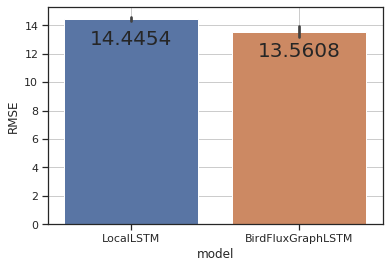

In [106]:
fig = utils.plot_average_errors(results_fixed_boundary_std005, boundary=boundary, night_only=True)

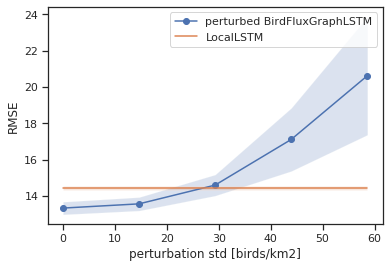

In [134]:
bird_scale = 293
fig = plot_sensitivity([results_fixed_boundary,
                 results_fixed_boundary_std005,
                 results_fixed_boundary_std01,
                 results_fixed_boundary_std015,
                 results_fixed_boundary_std02],
                 np.array([0, 0.05, 0.1, 0.15, 0.2]) * bird_scale, 'BirdFluxGraphLSTM')
fig.savefig('/home/fiona/birdMigration/data/plots/BirdFluxGraphLSTM/sensitivity_to_boundary.png', bbox_inches='tight', dpi=300)

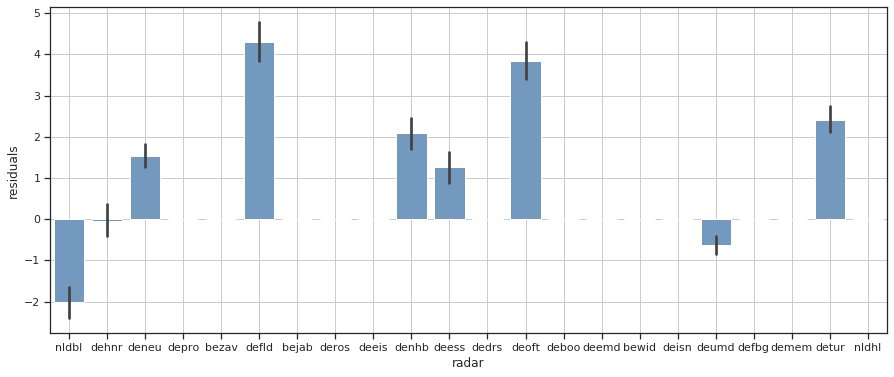

In [33]:
fig = utils.plot_errors_per_radar(results_fixed_boundary, 'BirdFluxGraphLSTM')

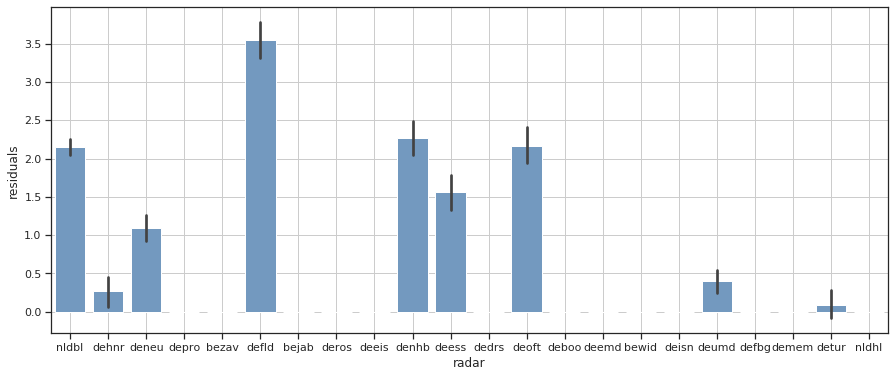

In [26]:
fig = utils.plot_errors_per_radar(results_boundary_fluxmlp, 'BirdFluxGraphLSTM')

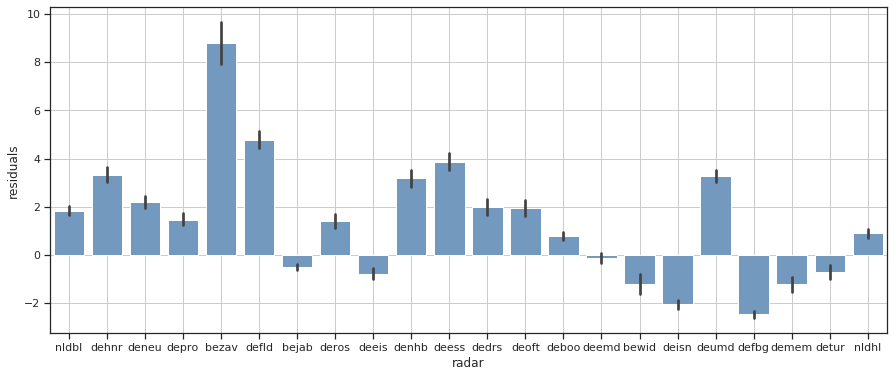

In [27]:
fig = utils.plot_errors_per_radar(results_boundary_lstm, 'BirdFluxGraphLSTM')

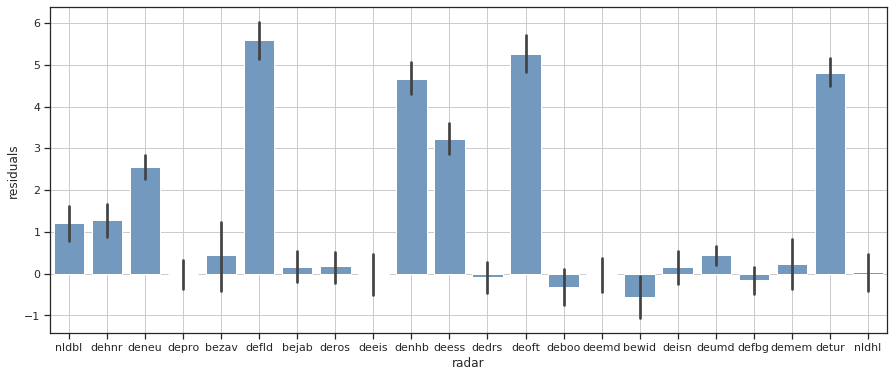

In [39]:
fig = utils.plot_errors_per_radar(results_fixed_boundary_std005, 'BirdFluxGraphLSTM')

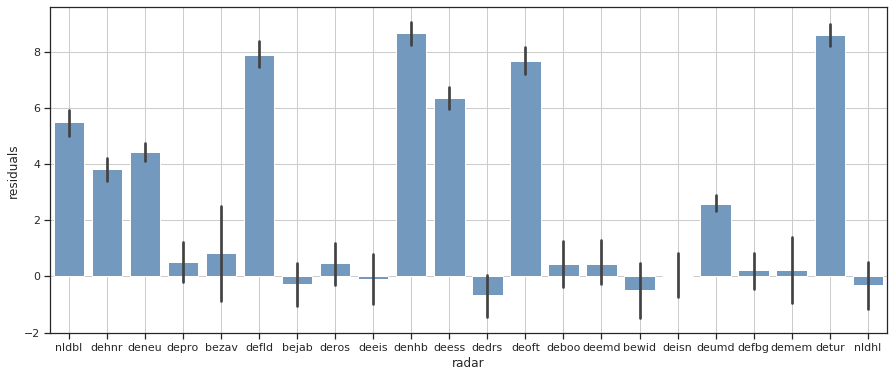

In [28]:
fig = utils.plot_errors_per_radar(results_fixed_boundary_std01, 'BirdFluxGraphLSTM')

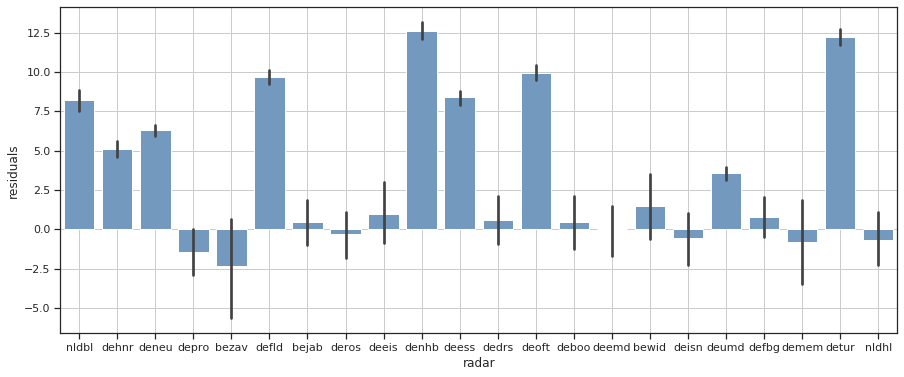

In [36]:
fig = utils.plot_errors_per_radar(results_fixed_boundary_std02, 'BirdFluxGraphLSTM')

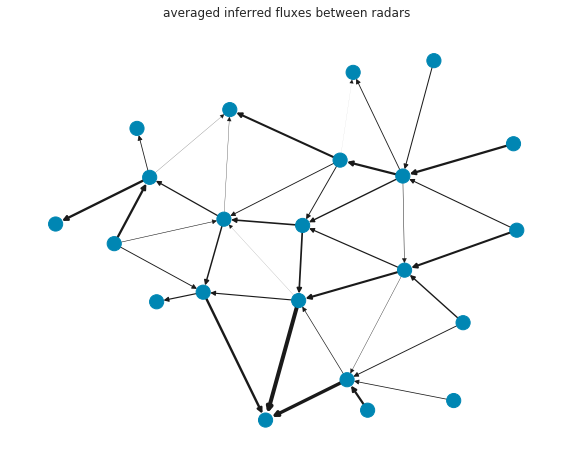

In [10]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

plot_fluxes(voronoi, G, fluxes_fixed_boundary, results_fixed_boundary, trial=0)

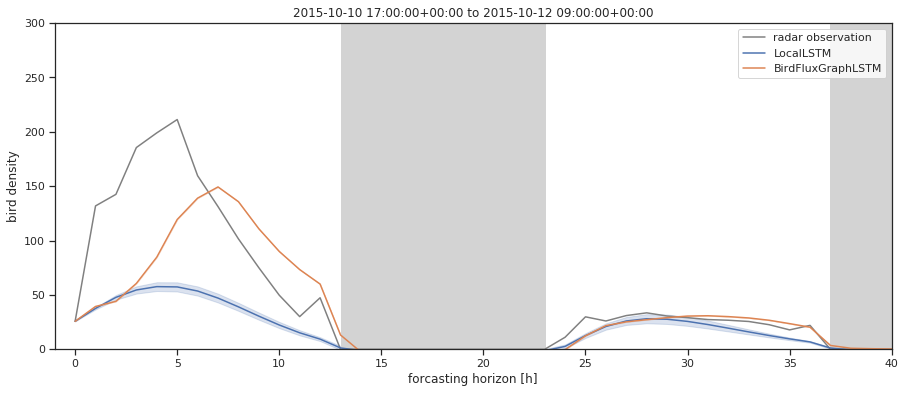

In [44]:
fig = utils.plot_example_prediction(results_fixed_boundary, 'denhb', 44, max=300)

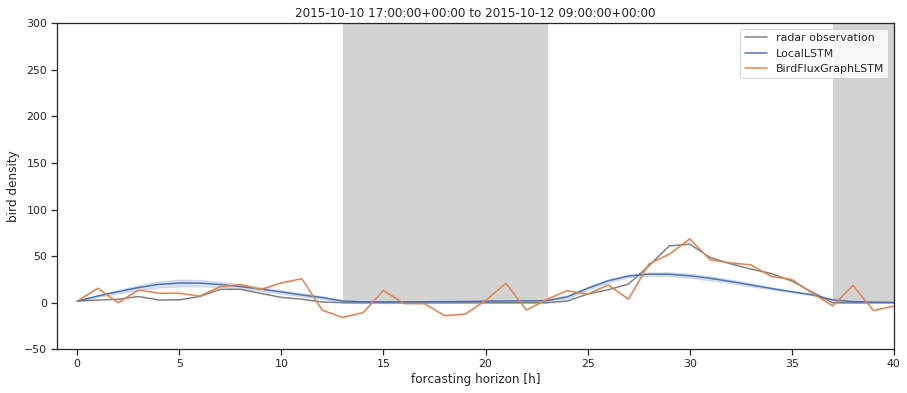

In [49]:
fig = utils.plot_example_prediction(results_fixed_boundary_std005, 'defbg', 44, max=300, min=-50)

In [7]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'boundary_lstm_without_dummy_radars']
results_boundary_lstm, bird_scales_boundary_lstm, fluxes_boundary_lstm, _ = load_results(models, experiments, base_dir)

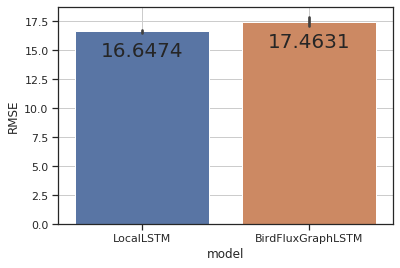

In [14]:
fig = utils.plot_average_errors(results_boundary_lstm, boundary=[], night_only=True)

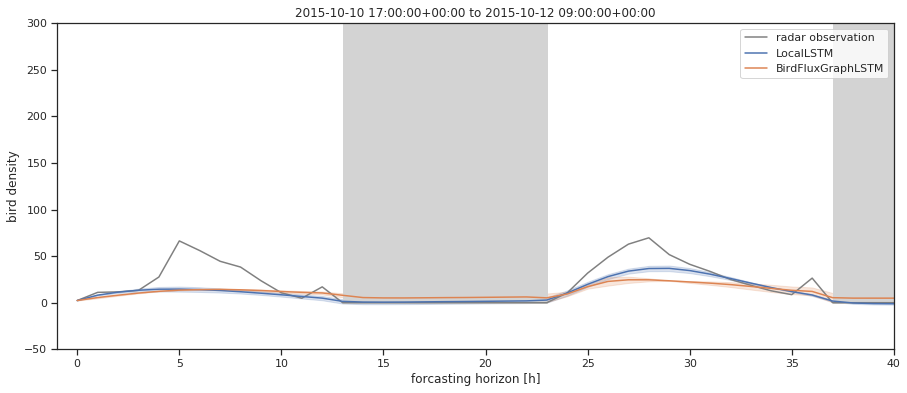

In [20]:
fig = utils.plot_example_prediction(results_boundary_lstm, 'detur', 44, max=300, min=-50)

In [6]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'boundary_fluxmlp_without_dummy_radars_constrained_fluxes01_dayofyear']
results_boundary_fluxmlp, bird_scales_boundary_fluxmlp, fluxes_boundary_fluxmlp, _ = load_results(models, experiments, base_dir)

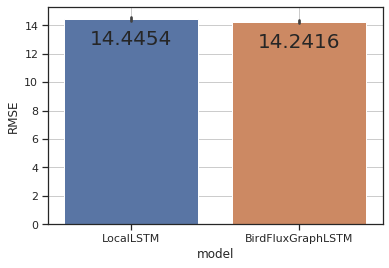

In [96]:
fig = utils.plot_average_errors(results_boundary_fluxmlp, boundary=boundary, night_only=True)

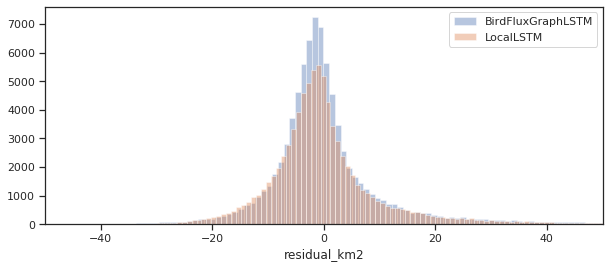

In [158]:
fig, ax = plt.subplots(figsize=(10,4))
df = results_boundary_fluxmlp['BirdFluxGraphLSTM'].query(f'night == True & missing == False & radar not in {list(boundary)} & horizon > 0')
sb.distplot(df.residual_km2, kde=False, ax=ax, bins=300, label='BirdFluxGraphLSTM')
df = results_boundary_fluxmlp['LocalLSTM'].query(f'night == True & missing == False & horizon > 0 & radar not in {list(boundary)}')
sb.distplot(df['gt_km2'] - df['prediction_km2'], kde=False, ax=ax, bins=300, label='LocalLSTM')
ax.set(xlim=(-50, 50))
ax.legend()

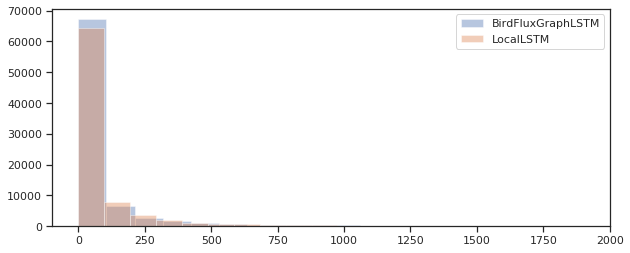

In [164]:
fig, ax = plt.subplots(figsize=(10,4))
df = results_boundary_fluxmlp['BirdFluxGraphLSTM'].query(f'night == True & missing == False & radar not in {list(boundary)} & horizon > 0')
sb.distplot(np.power(df.residual_km2.to_numpy(), 2), kde=False, ax=ax, bins=500, label='BirdFluxGraphLSTM')
df = results_boundary_fluxmlp['LocalLSTM'].query(f'night == True & missing == False & horizon > 0 & radar not in {list(boundary)}')
sb.distplot(np.power((df['gt_km2'] - df['prediction_km2']).to_numpy(), 2), kde=False, ax=ax, bins=500, label='LocalLSTM')
ax.set(xlim=(-100, 2000))
ax.legend()

In [117]:
trial = 0
all_radar_fluxes = []
all_model_fluxes = []
for nidx in range(50):
    diff = fluxes_boundary_fluxmlp[1][trial][nidx] - fluxes_boundary_fluxmlp[0][trial][nidx]
    constraints = (diff[~torch.isnan(diff)]**2).sum() / 100
    radar = fluxes_boundary_fluxmlp[1][trial][nidx]
    all_radar_fluxes.append(radar)
    avg_radar = radar[~torch.isnan(radar)].max()
    model = fluxes_boundary_fluxmlp[0][trial][nidx]
    all_model_fluxes.append(model)
    avg_model = model[~torch.isnan(model)].max()
    #print(avg_radar, avg_model, constraints)
all_radar_fluxes = torch.cat(all_radar_fluxes).view(-1, 1)
all_radar_fluxes = all_radar_fluxes[all_radar_fluxes != 0]
all_model_fluxes = torch.cat(all_model_fluxes).view(-1, 1)
all_model_fluxes = all_model_fluxes[all_model_fluxes != 0].detach().numpy()

[(0, 100), (-0.05, 0.05)]

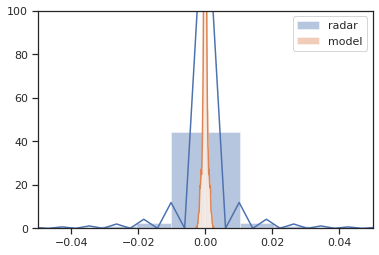

In [125]:
fig, ax = plt.subplots()
sb.distplot(all_radar_fluxes, ax=ax, label='radar')
sb.distplot(all_model_fluxes, ax=ax, label='model')
ax.legend()
ax.set(xlim=(-0.05, 0.05), ylim=(0, 100))

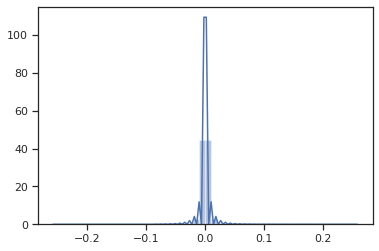

In [124]:
sb.distplot(all_radar_fluxes)

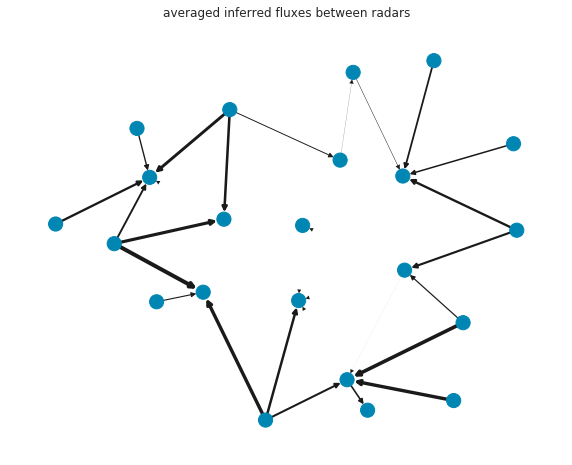

In [104]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes_boundary_fluxmlp[0], results_boundary_fluxmlp, trial=0)

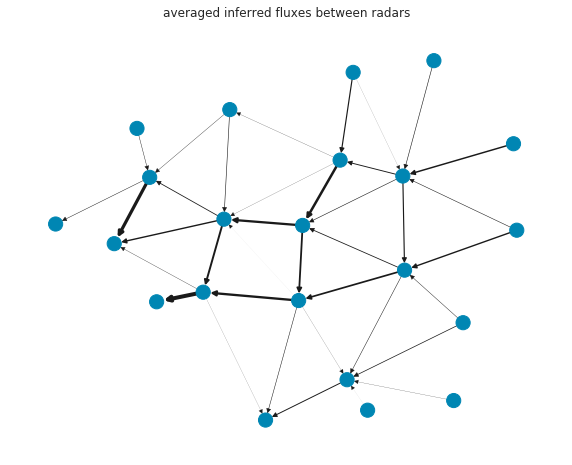

In [91]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes_boundary_fluxmlp[1], results_boundary_fluxmlp, trial=0)

In [100]:
for i, j, data in G_new.edges(data=True):
    print(G_new.nodes(data=True)[i]['radar'], G_new.nodes(data=True)[j]['radar'], data['flux'])

bezav nldbl 0.00010957938
bezav denhb 0.00023279512
bezav deess 0.00018247857
bejab nldbl 0.00013410299
deess nldbl 1.6014144e-10
deemd nldbl 0.0001708196
deemd dehnr 5.54868e-05
deemd deess 0.00014887616
nldhl nldbl 7.93063e-05
dehnr deboo 8.992134e-06
defld deoft 6.373629e-09
deboo deumd 2.7404076e-05
deneu defld 2.338065e-09
deneu deoft 4.640899e-08
deneu detur 1.4023266e-06
deeis deneu 6.9986454e-05
deeis detur 0.00021025748
dedrs deneu 0.0001248841
dedrs deumd 0.00013647869
detur deoft 1.2715231e-08
detur demem 9.3910916e-05
depro deumd 8.8123496e-05
deros deumd 0.000104112885
bewid denhb 6.421182e-05
deisn detur 0.00019771815
defbg denhb 0.00019738739
defbg deoft 0.00014330154
defbg detur 0.00011791852


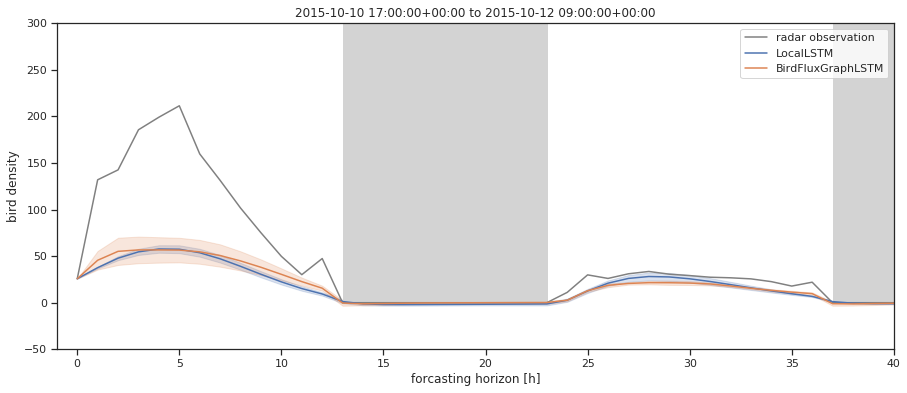

In [25]:
fig = utils.plot_example_prediction(results_boundary_fluxmlp, 'denhb', 44, max=300, min=-50)

In [63]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'fixed_boundary_without_dummy_radars_sigmoid']
results_fixed, bird_scales_fixed, fluxes_fixed, _ = load_results(models, experiments, base_dir)

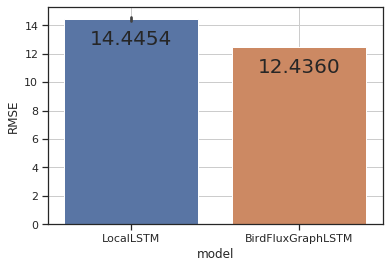

In [64]:
fig = utils.plot_average_errors(results_fixed, boundary=boundary, night_only=True)

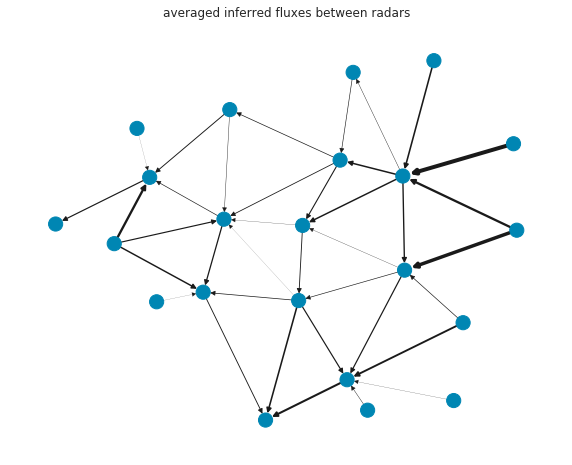

In [65]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes_fixed[0], results_fixed, trial=0)

In [58]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'boundary_fluxmlp_without_dummy_radars_constrained_boundary_fluxes02_sigmoid']
results_constrained_boundary_fluxmlp, bird_scales_constrained_boundary_fluxmlp, fluxes_constrained_boundary_fluxmlp, _ = load_results(models, experiments, base_dir)

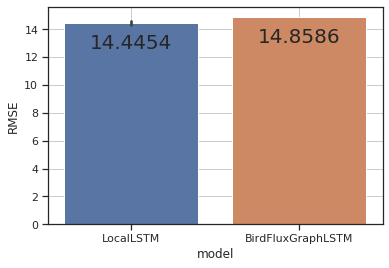

In [7]:
fig = utils.plot_average_errors(results_constrained_boundary_fluxmlp, boundary=boundary, night_only=True)

4.282726e-09 1.5963106e-07
4.224791e-09 1.7374556e-07
1.3200128e-07 1.2136732e-07
3.5969059e-09 1.5045624e-07
1.2890433e-09 6.3176074e-08
1.4611092e-07 1.5007497e-07
3.1748732e-07 2.9290862e-07
9.768485e-10 8.326601e-08
5.9484706e-10 1.0049434e-07
9.535007e-08 8.904837e-08
3.7118508e-07 3.7709228e-07
2.5740858e-09 3.329578e-07
1.9594477e-09 4.0897322e-07
3.8816466e-07 3.5437668e-07
2.4746325e-07 2.2934188e-07
1.0076841e-06 1.0231728e-06
1.18828886e-07 5.500497e-10
1.5963106e-07 4.282726e-09
5.147878e-07 7.4983e-09
2.9415315e-07 4.3109103e-09
1.5007497e-07 1.4611092e-07
3.7709228e-07 3.7118508e-07
1.570058e-07 1.587765e-07
2.8865156e-07 2.9310084e-07
3.2749557e-07 3.3562534e-07
1.7374556e-07 4.224791e-09
1.4978355e-07 7.8677354e-10
3.329578e-07 2.5740858e-09
1.1612772e-06 7.709953e-09
7.4983e-09 5.147878e-07
2.6635013e-07 2.5368053e-07
2.6519064e-07 2.5580937e-07
4.646147e-09 1.8658977e-07
1.0171259e-08 9.219308e-07
1.2136732e-07 1.3200128e-07
2.9290862e-07 3.1748732e-07
4.3109103e-09 2

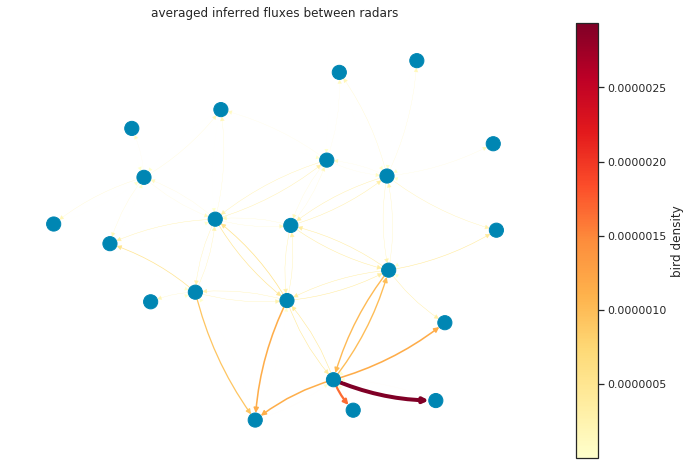

In [16]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/ahome/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes_constrained_boundary_fluxmlp[0], results_constrained_boundary_fluxmlp, trial=0)

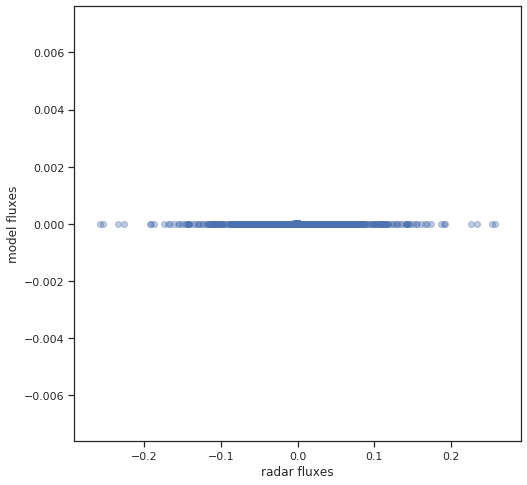

In [59]:
compare_fluxes(fluxes_constrained_boundary_fluxmlp[0], fluxes_constrained_boundary_fluxmlp[1], trial=0, context=0)

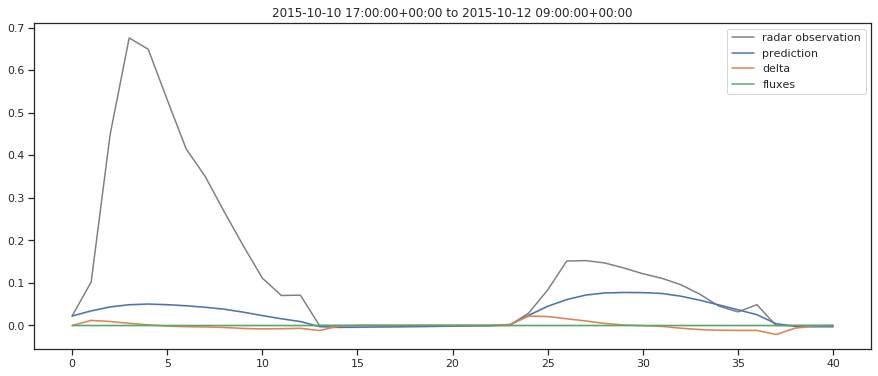

In [11]:
m = 'BirdFluxGraphLSTM'
seqID = 44
radar = 'deoft'
fig, ax = plt.subplots(figsize=(15, 6))

r = results_constrained_boundary_fluxmlp[m].query(f'seqID == {seqID} & radar == "{radar}"')

r0 = r.query(f'trial == 0')
ax.plot(range(len(r0)), r0['gt'] / bird_scales_constrained_boundary_fluxmlp[m], label='radar observation', color='gray')

all_predictions = []
all_deltas = []
all_fluxes = []
for trial in r.trial.unique():
    r_t = r.query(f'trial == {trial}')
    all_predictions.append(r_t['prediction'] / bird_scales_constrained_boundary_fluxmlp[m])
    all_deltas.append(r_t['local_deltas'])
    all_fluxes.append(r_t['fluxes'])
#     all_deltas.append(r_t['delta'])
#     all_fluxes.append(r_t['influx'])
    #print(r_t['local_deltas'])
all_predictions = np.stack(all_predictions, axis=0)
all_deltas = np.stack(all_deltas, axis=0) #* 10
all_fluxes = np.stack(all_fluxes, axis=0)

line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_deltas.shape[1]), all_deltas.mean(0), label='delta')
ax.fill_between(range(all_deltas.shape[1]), all_deltas.mean(0) - all_deltas.std(0),
                all_deltas.mean(0) + all_deltas.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_fluxes.shape[1]), all_fluxes.mean(0), label='fluxes')
ax.fill_between(range(all_fluxes.shape[1]), all_fluxes.mean(0) - all_fluxes.std(0),
                all_fluxes.mean(0) + all_fluxes.std(0), color=line[0].get_color(), alpha=0.2)

#ax.set(ylim=(0, 0.4), xlim=(-1, 40), xlabel='forcasting horizon [h]', ylabel='normalized bird density')
ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
plt.legend()

In [71]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_new',
              'boundary_fluxmlp_with_dummy_radars_constrained_boundary_fluxes02_sigmoid_encoder']
results_encoder3, bird_scales_encoder3, fluxes_encoder3, _ = load_results(models, experiments, base_dir)

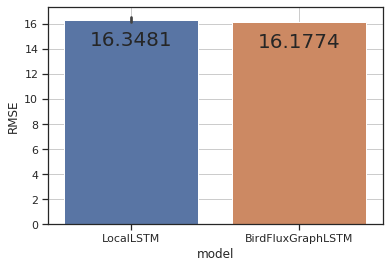

In [72]:
fig = utils.plot_average_errors(results_encoder3, boundary=[], night_only=True)

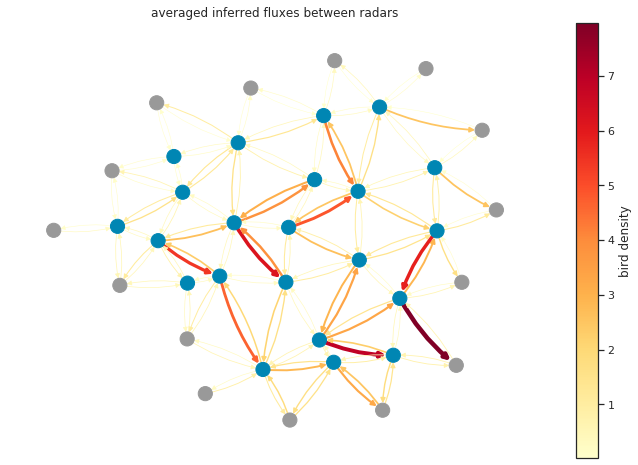

In [73]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes_encoder3[0], results_encoder3, trial=0, encoder=1, bird_scale=bird_scales_encoder3['BirdFluxGraphLSTM'])

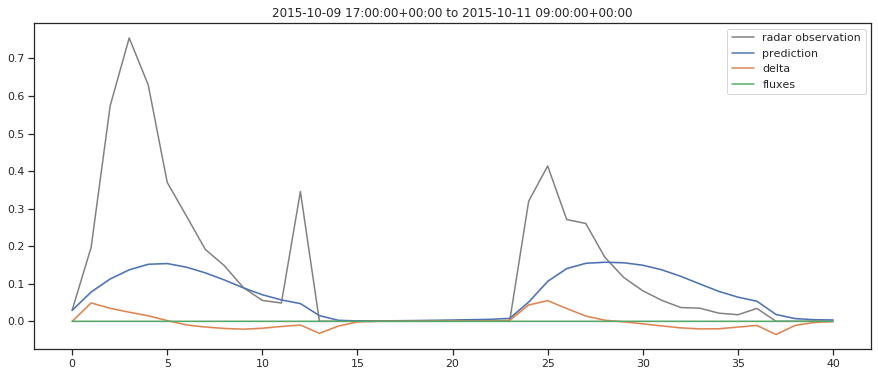

In [67]:
m = 'BirdFluxGraphLSTM'
seqID = 43
radar = 'dehnr'
fig, ax = plt.subplots(figsize=(15, 6))

r = results_encoder3[m].query(f'seqID == {seqID} & radar == "{radar}"')

r0 = r.query(f'trial == 0')
ax.plot(range(len(r0)), r0['gt'] / bird_scales_encoder3[m], label='radar observation', color='gray')

all_predictions = []
all_deltas = []
all_fluxes = []
for trial in r.trial.unique():
    r_t = r.query(f'trial == {trial}')
    all_predictions.append(r_t['prediction'] / bird_scales_encoder3[m])
    all_deltas.append(r_t['local_deltas'])
    all_fluxes.append(r_t['fluxes'])
#     all_deltas.append(r_t['delta'])
#     all_fluxes.append(r_t['influx'])
    #print(r_t['local_deltas'])
all_predictions = np.stack(all_predictions, axis=0)
all_deltas = np.stack(all_deltas, axis=0) #* 10
all_fluxes = np.stack(all_fluxes, axis=0)

line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_deltas.shape[1]), all_deltas.mean(0), label='delta')
ax.fill_between(range(all_deltas.shape[1]), all_deltas.mean(0) - all_deltas.std(0),
                all_deltas.mean(0) + all_deltas.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_fluxes.shape[1]), all_fluxes.mean(0), label='fluxes')
ax.fill_between(range(all_fluxes.shape[1]), all_fluxes.mean(0) - all_fluxes.std(0),
                all_fluxes.mean(0) + all_fluxes.std(0), color=line[0].get_color(), alpha=0.2)

#ax.set(ylim=(0, 0.4), xlim=(-1, 40), xlabel='forcasting horizon [h]', ylabel='normalized bird density')
ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
plt.legend()

In [74]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_new',
              'boundary_fluxmlp_without_dummy_radars_constrained_fluxes02_sigmoid_encoder']
results_encoder4, bird_scales_encoder4, fluxes_encoder4, _ = load_results(models, experiments, base_dir)

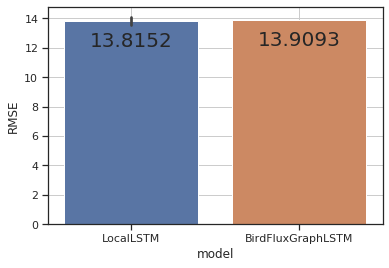

In [75]:
fig = utils.plot_average_errors(results_encoder4, boundary=boundary, night_only=True)

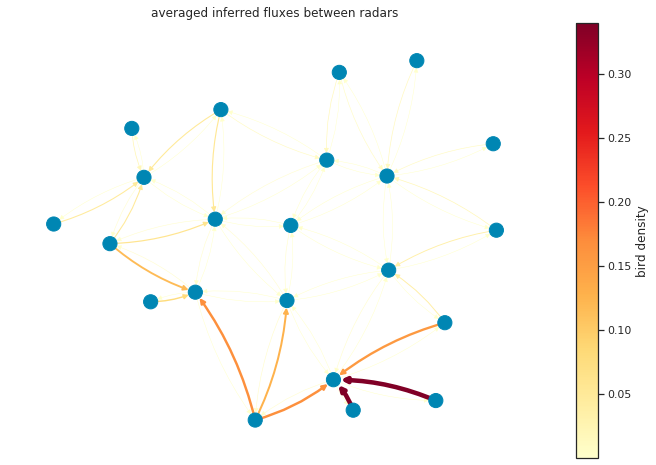

In [76]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes_encoder4[0], results_encoder4, trial=0, encoder=1, bird_scale=bird_scales_encoder4['BirdFluxGraphLSTM'])

In [86]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_new',
              'boundary_fluxmlp_without_dummy_radars_sigmoid_encoder']
results_encoder5, bird_scales_encoder5, fluxes_encoder5, _ = load_results(models, experiments, base_dir)

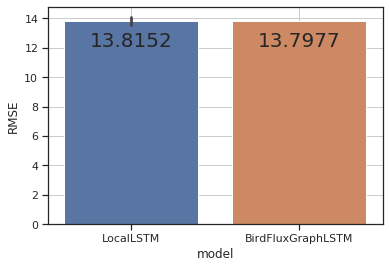

In [87]:
fig = utils.plot_average_errors(results_encoder5, boundary=boundary, night_only=True)

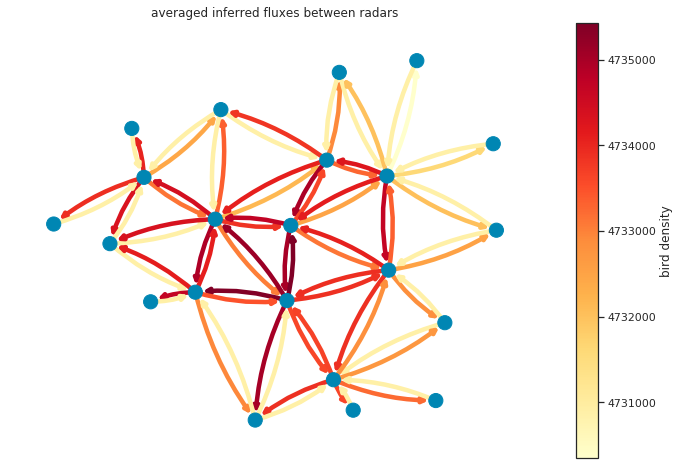

In [88]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes_encoder5[0], results_encoder5, trial=0, encoder=1, bird_scale=bird_scales_encoder5['BirdFluxGraphLSTM'])

In [92]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_new',
              'boundary_fluxmlp_without_dummy_radars_constrained_boundary_fluxes02_sigmoid_encoder_weighted_fluxes']
results_encoder2_weighted, bird_scales_encoder2_weighted, fluxes_encoder2_weighted, _ = load_results(models, experiments, base_dir)

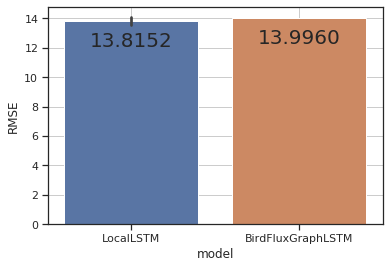

In [93]:
fig = utils.plot_average_errors(results_encoder2_weighted, boundary=boundary, night_only=True)

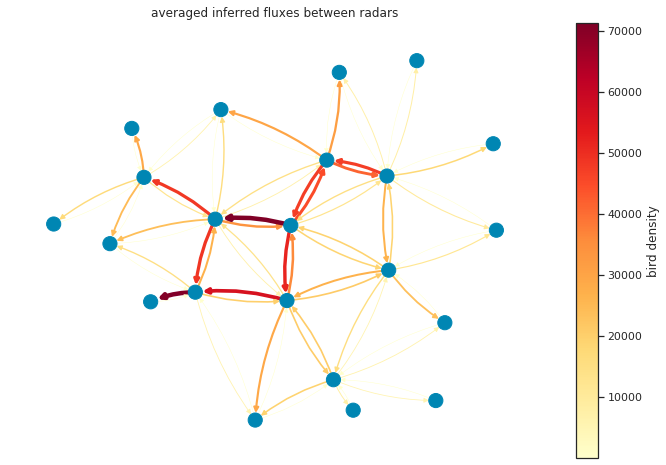

In [103]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes_encoder2_weighted[0], results_encoder2_weighted, trial=0, encoder=1, bird_scale=bird_scales_encoder2_weighted['BirdFluxGraphLSTM'])

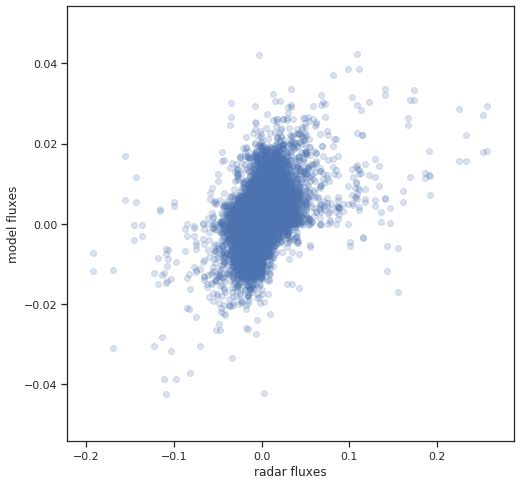

In [106]:
compare_fluxes(inner_radars, fluxes_encoder2_weighted[0], fluxes_encoder2_weighted[1], trial=0, context=24)

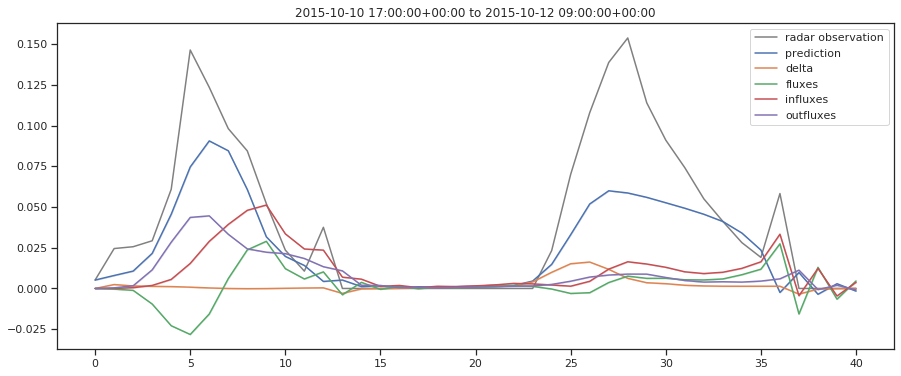

In [116]:
m = 'BirdFluxGraphLSTM'
seqID = 44
radar = 'detur'
fig, ax = plt.subplots(figsize=(15, 6))

r = results_encoder2_weighted[m].query(f'seqID == {seqID} & radar == "{radar}"')

r0 = r.query(f'trial == 0')
ax.plot(range(len(r0)), r0['gt'] / bird_scales_encoder2_weighted[m], label='radar observation', color='gray')

all_predictions = []
all_deltas = []
all_fluxes = []
all_influxes = []
all_outfluxes = []
for trial in r.trial.unique():
    r_t = r.query(f'trial == {trial}')
    all_predictions.append(r_t['prediction'] / bird_scales_encoder2_weighted[m])
    all_deltas.append(r_t['local_deltas'])
    all_fluxes.append(r_t['fluxes'])
    all_influxes.append(r_t['influxes'])
    all_outfluxes.append(r_t['outfluxes'])
    
all_predictions = np.stack(all_predictions, axis=0)
all_deltas = np.stack(all_deltas, axis=0) #* 10
all_fluxes = np.stack(all_fluxes, axis=0)
all_influxes = np.stack(all_influxes, axis=0)
all_outfluxes = np.stack(all_outfluxes, axis=0)

line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_deltas.shape[1]), all_deltas.mean(0), label='delta')
ax.fill_between(range(all_deltas.shape[1]), all_deltas.mean(0) - all_deltas.std(0),
                all_deltas.mean(0) + all_deltas.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_fluxes.shape[1]), all_fluxes.mean(0), label='fluxes')
ax.fill_between(range(all_fluxes.shape[1]), all_fluxes.mean(0) - all_fluxes.std(0),
                all_fluxes.mean(0) + all_fluxes.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_influxes.shape[1]), all_influxes.mean(0), label='influxes')
ax.fill_between(range(all_influxes.shape[1]), all_influxes.mean(0) - all_influxes.std(0),
                all_influxes.mean(0) + all_influxes.std(0), color=line[0].get_color(), alpha=0.2)


line = ax.plot(range(all_outfluxes.shape[1]), all_outfluxes.mean(0), label='outfluxes')
ax.fill_between(range(all_outfluxes.shape[1]), all_outfluxes.mean(0) - all_outfluxes.std(0),
                all_outfluxes.mean(0) + all_outfluxes.std(0), color=line[0].get_color(), alpha=0.2)
#ax.set(ylim=(0, 0.4), xlim=(-1, 40), xlabel='forcasting horizon [h]', ylabel='normalized bird density')
ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
plt.legend()

In [89]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_new',
              'boundary_fluxmlp_without_dummy_radars_constrained_boundary_fluxes02_sigmoid_encoder_lower_lr']
results_encoder2_lr, bird_scales_encoder2_lr, fluxes_encoder2_lr, _ = load_results(models, experiments, base_dir)

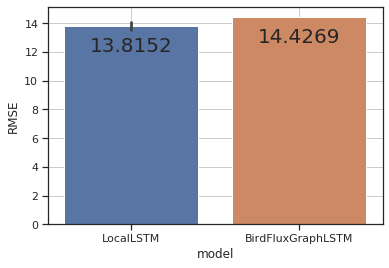

In [90]:
fig = utils.plot_average_errors(results_encoder2_lr, boundary=boundary, night_only=True)

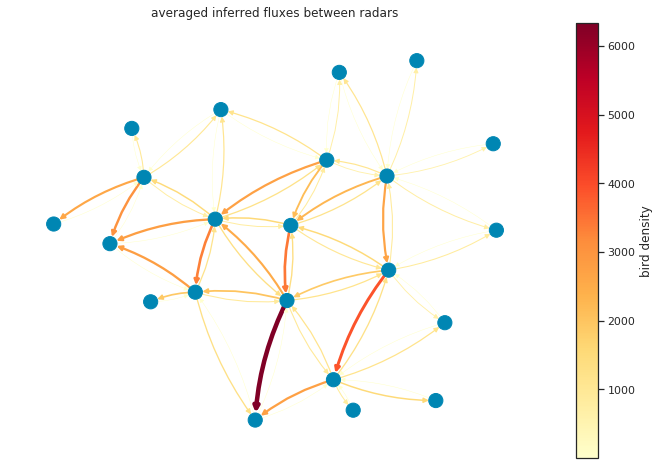

In [91]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes_encoder2_lr[0], results_encoder2_lr, trial=0, encoder=1, bird_scale=bird_scales_encoder2_lr['BirdFluxGraphLSTM'])

In [50]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_new',
              'boundary_fluxmlp_without_dummy_radars_constrained_boundary_fluxes02_sigmoid_encoder']
results_encoder2, bird_scales_encoder2, fluxes_encoder2, _ = load_results(models, experiments, base_dir)

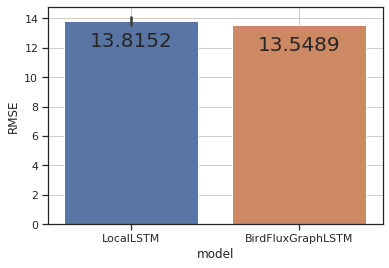

In [13]:
fig = utils.plot_average_errors(results_encoder2, boundary=boundary, night_only=True)

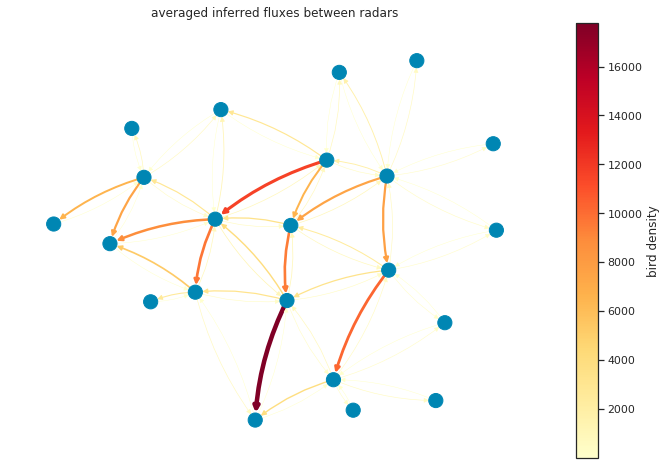

In [107]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes_encoder2[0], results_encoder2, trial=0, encoder=1, bird_scale=bird_scales_encoder2['BirdFluxGraphLSTM'])

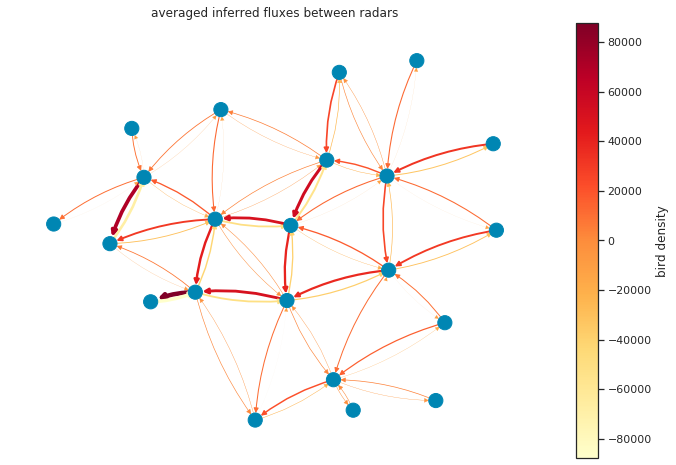

In [62]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes_encoder2[1], results_encoder2, trial=0, encoder=1, context=24, bird_scale=bird_scales_encoder2['BirdFluxGraphLSTM'])

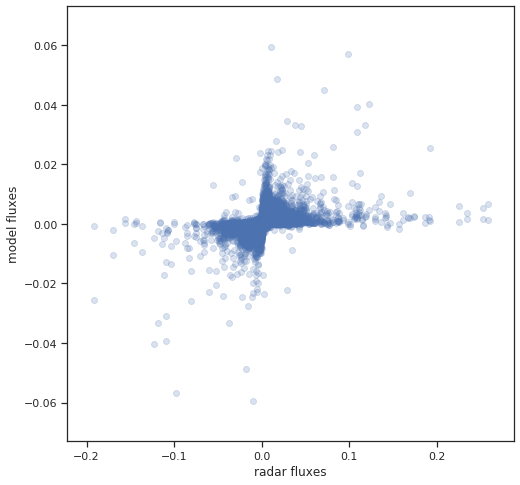

In [108]:
compare_fluxes(inner_radars, fluxes_encoder2[0], fluxes_encoder2[1], trial=0, context=24)

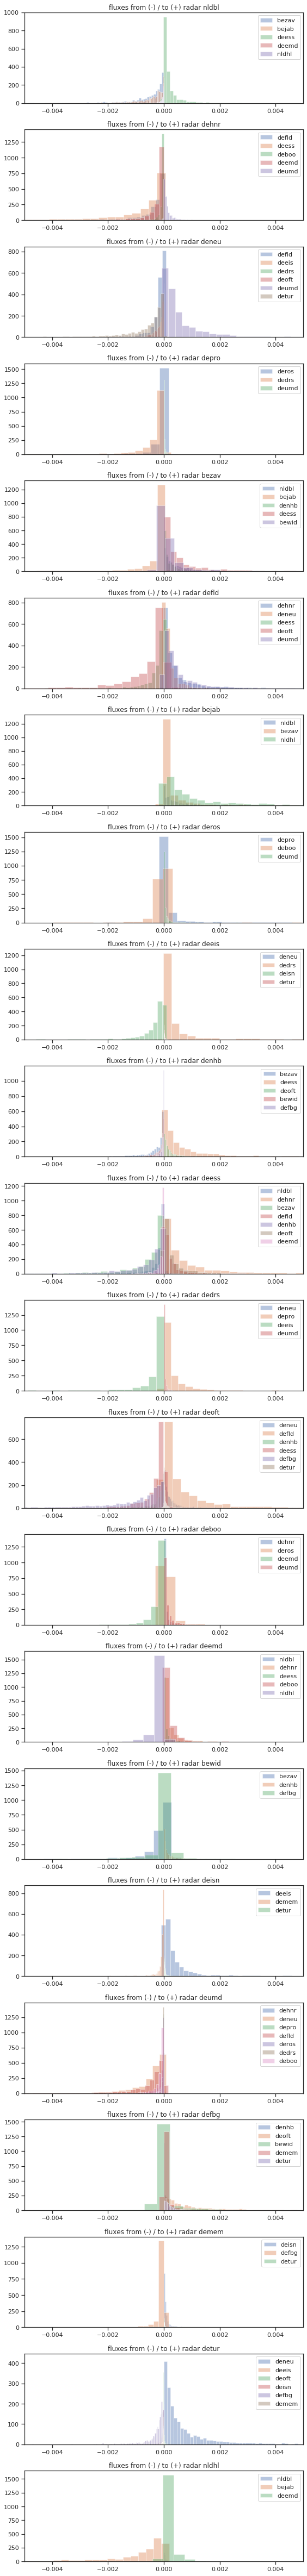

In [85]:
trial = 0
f = torch.cat([f for f in fluxes_encoder2[0][trial].values()], dim=-1)
mask = np.concatenate([results_encoder2['BirdFluxGraphLSTM'].query(f'seqID == {i+1}').groupby('horizon').night.all().values for i in range(len(fluxes_encoder2[0][trial]))])

radars = results_encoder2['BirdFluxGraphLSTM'].radar.unique()
fig, ax = plt.subplots(len(radars), 1, figsize=(8, 3 * len(radars)))
for i, ri in enumerate(radars):
    for j, rj in enumerate(radars):
        if f[i,j].mean() != 0:
            fluxes = f[j,i, mask].detach().numpy() - f[i,j, mask].detach().numpy()
            sb.distplot(fluxes, kde=False, ax=ax[i], label=rj, bins=200)
    ax[i].set_title(f'fluxes from (-) / to (+) radar {ri}')
    ax[i].set(xlim=(-0.005, 0.005))
    ax[i].legend()
plt.tight_layout()

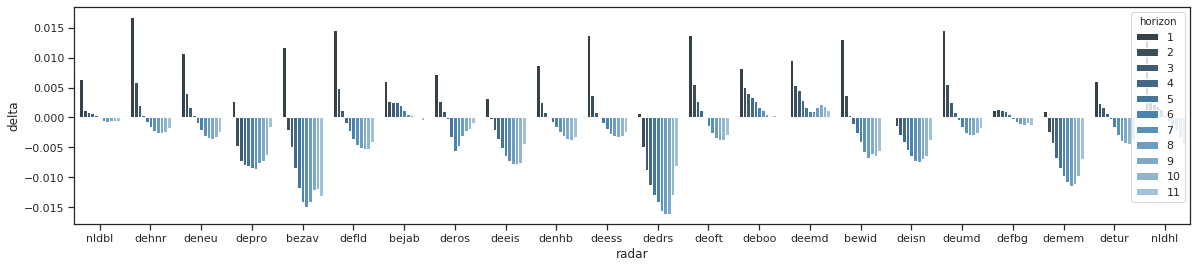

In [78]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='local_deltas', hue='horizon', data=results_encoder2['BirdFluxGraphLSTM'].query('night == True & horizon != 0 & horizon < 12'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='delta');

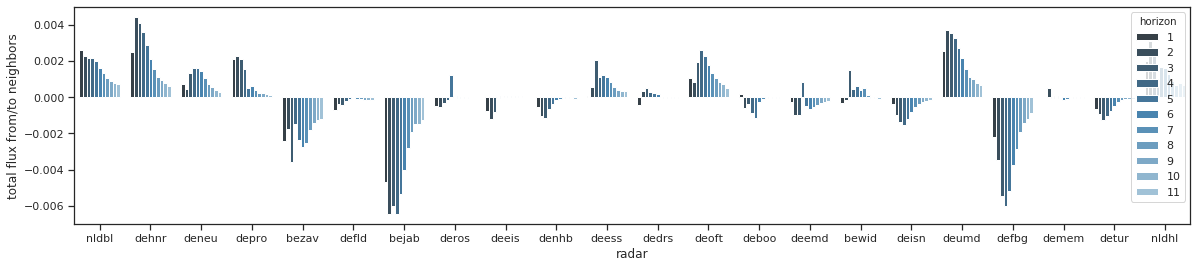

In [79]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='fluxes', hue='horizon', data=results_encoder2['BirdFluxGraphLSTM'].query('night == True & horizon != 0 & horizon < 12'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='total flux from/to neighbors');

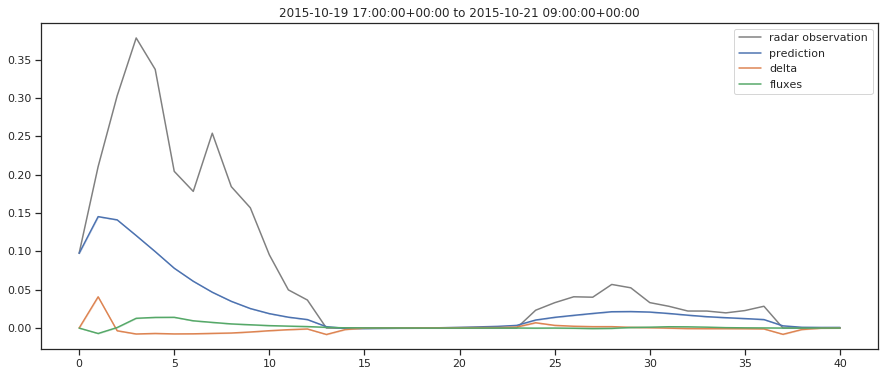

In [77]:
m = 'BirdFluxGraphLSTM'
seqID = 53
radar = 'deess'
fig, ax = plt.subplots(figsize=(15, 6))

r = results_encoder2[m].query(f'seqID == {seqID} & radar == "{radar}"')

r0 = r.query(f'trial == 0')
ax.plot(range(len(r0)), r0['gt'] / bird_scales_encoder2[m], label='radar observation', color='gray')

all_predictions = []
all_deltas = []
all_fluxes = []
for trial in r.trial.unique():
    r_t = r.query(f'trial == {trial}')
    all_predictions.append(r_t['prediction'] / bird_scales_encoder2[m])
    all_deltas.append(r_t['local_deltas'])
    all_fluxes.append(r_t['fluxes'])
#     all_deltas.append(r_t['delta'])
#     all_fluxes.append(r_t['influx'])
    #print(r_t['local_deltas'])
all_predictions = np.stack(all_predictions, axis=0)
all_deltas = np.stack(all_deltas, axis=0) #* 10
all_fluxes = np.stack(all_fluxes, axis=0)

line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_deltas.shape[1]), all_deltas.mean(0), label='delta')
ax.fill_between(range(all_deltas.shape[1]), all_deltas.mean(0) - all_deltas.std(0),
                all_deltas.mean(0) + all_deltas.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_fluxes.shape[1]), all_fluxes.mean(0), label='fluxes')
ax.fill_between(range(all_fluxes.shape[1]), all_fluxes.mean(0) - all_fluxes.std(0),
                all_fluxes.mean(0) + all_fluxes.std(0), color=line[0].get_color(), alpha=0.2)

#ax.set(ylim=(0, 0.4), xlim=(-1, 40), xlabel='forcasting horizon [h]', ylabel='normalized bird density')
ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
plt.legend()

In [82]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_new',
              #'fixed_boundary_without_dummy_radars_encoder_new']
               'boundary_fluxmlp_without_dummy_radars_encoder']
results_encoder, bird_scales_encoder, fluxes_encoder, _ = load_results(models, experiments, base_dir)

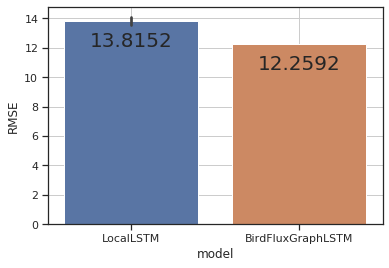

In [67]:
fig = utils.plot_average_errors(results_encoder, boundary=boundary, night_only=True)

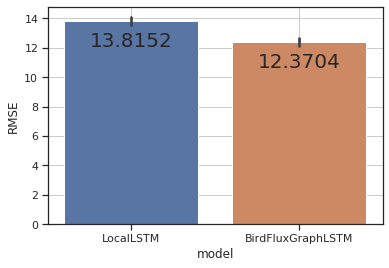

In [83]:
fig = utils.plot_average_errors(results_encoder, boundary=boundary, night_only=True)

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


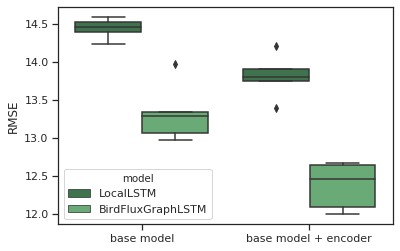

In [85]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
results = {'base model': results_fixed_boundary, 
           'base model + encoder': results_encoder}

df_compare = dict(RMSE = [], model=[], experiment=[])
for label, r in results.items():
    for m in models:
        df = r[m].query(f'missing == False & radar not in {list(boundary)} & night == True')
        df['error'] = (df['gt_km2'] - df['prediction_km2']) ** 2
        df = df.groupby('trial')
        rmse = df.error.aggregate(np.nanmean).apply(np.sqrt)
        df_compare['RMSE'].extend(rmse.values)
        df_compare['model'].extend([m] * len(rmse))
        df_compare['experiment'].extend([label] * len(rmse))
df_compare = pd.DataFrame(df_compare) 
fig, ax = plt.subplots()
sb.boxplot(x='experiment', y='RMSE', hue='model', data=df_compare, ax=ax, palette="Greens_d")
ax.set(xlabel="");

In [86]:
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/encoder_fixed_boundary_performance.png', bbox_inches='tight', dpi=300)

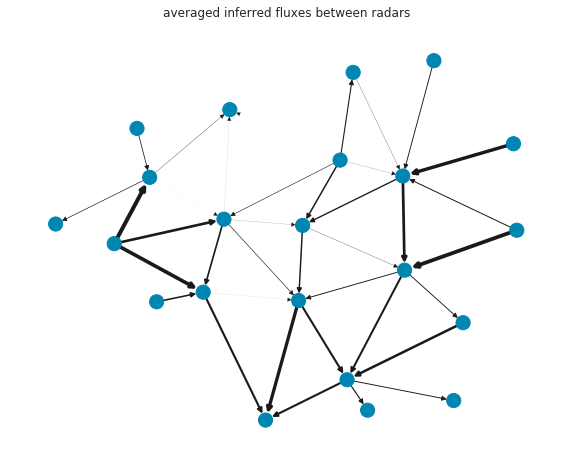

In [94]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes_encoder[0], results_encoder, trial=0)

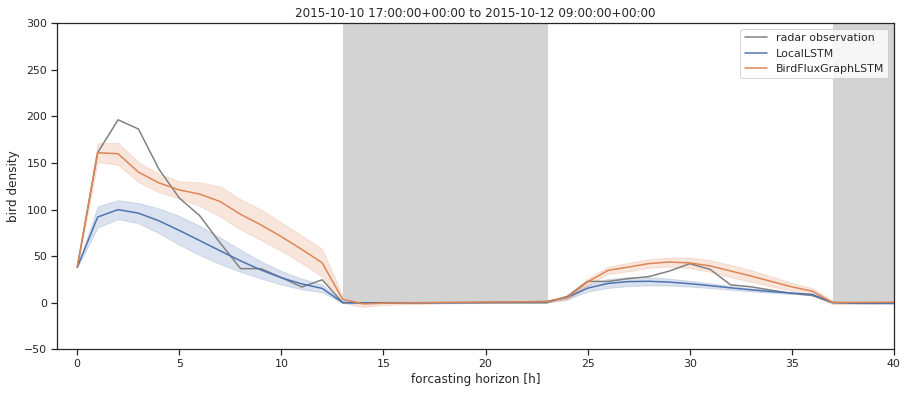

In [17]:
fig = utils.plot_example_prediction(results_encoder, 'deess', 44, max=300, min=-50)